<a href="https://colab.research.google.com/github/eunjeongpak/projects/blob/main/AI_04_%EB%B0%95%EC%9D%80%EC%A0%95_section4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section4 project
# 텍스트 감정 분석 모델 Sentiment Analysis

**주제 선정**
- 회사에서는 소비자(사용자)가 느끼는 생각을 알기 위해 회사의 제품이나 서비스에 대한 사용자 리뷰 데이터 분석을 시행
- 이때 텍스트 감정 분석 or NLP 기반의 키워드 추출을 사용
- 따라서 텍스트와 같은 비정형 데이터 처리하는 스킬을 기르기 위해 감정 분석 모델이라는 주제를 선정


**사용한 데이터**

- 크롤링을 통해 한 브랜드의 리뷰 데이터를 수집하려고 했으나 시간 상의 문제로 깃허브에 공개된 데이터 사용
- 출처: https://github.com/bab2min/corpus/blob/master/sentiment/README.md


- 데이터: 네이버 쇼핑 리뷰 데이터 
  - 네이버 쇼핑에서 제품별 후기를 별점과 함께 수집

-	데이터 정보
  - 데이터 수: 200,000 개
  - 의류, 잡화, 미용, 가전, 식품 등 다양한 분야 상품 포함
  - 2020.06 ~ 2020.07 데이터
  - 긍/부정으로 분류하기 애매한 3점에 해당하는 텍스트들은 제외
  - 긍정(4 ~ 5점) & 부정(1 ~2 점)의 비율이 1:1에 가깝도록 샘플링
  - 데이터 분포: 긍정(99,963), 부정(100,037)



**사용한 모델**
- GRU
- BERT

# 필요한 라이브러리 설치

- 한국어 자연어 처리 konlpy, 형태소 분석기 Mecab 설치, 필요한 라이브러리 설치

In [ ]:
pip install konlpy

In [ ]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [3]:
import re
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from collections import Counter

from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings(action="ignore")

# 네이버 쇼핑 리뷰 데이터

- 네이버 쇼핑 리뷰 데이터 불러오기

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f9c43c37490>)

In [5]:
df = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
df[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [6]:
#총 데이터 개수
df.shape

(200000, 2)

In [ ]:
#ratings 비율 확인
df['ratings'].value_counts(normalize=True, ascending=False)

5    0.405885
2    0.319945
1    0.180240
4    0.093930
Name: ratings, dtype: float64

- 라벨 생성

In [7]:
#ratings 1,2 -> 0, 4,5 -> 1로 구분
df['label'] = np.where(df['ratings'].values > 3 , 1, 0)
df

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1
...,...,...,...
199995,2,장마라그런가!!! 달지않아요,0
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...,1
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요,1
199998,5,넘이쁘고 쎄련되보이네요~,1


In [ ]:
#label 비율 확인
df['label'].value_counts(normalize=True)

0    0.500185
1    0.499815
Name: label, dtype: float64

- 전처리(중복값 및 결측치 처리) 및 훈련/테스트 데이터 분리

In [8]:
#중복값 제거
df.drop_duplicates(subset=['reviews'], inplace=True)
print(len(df))

199908


In [9]:
#결측치(null값) 확인
df.isnull().sum()

ratings    0
reviews    0
label      0
dtype: int64

In [10]:
#훈련/테스트 데이터 분리
#테스트 데이터 -> 25%
train, test = train_test_split(df, test_size = 0.25, random_state = 42)
train.shape, test.shape

((149931, 3), (49977, 3))

In [13]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [25]:
train[:5]

,ratings,reviews,label
0,2,사이즈를 3센치씩 늘린건데도 작아요 그리고 색상은 완전 달라요 칙칙한핑크네요ㅠㅠ 많...,0
1,2,ㅂ불만족.. 빗이 아픔 .. 멍이피부에 빗질못해주겟네요,0
2,1,이 제품쓰고 삼일만에 변기물이 잘 안내려갔어요. 혹시나해서 다시 빼보니 물이 다시 ...,0
3,5,적당하고 만족합니다,1
4,2,편하자고 이용하는 밀키튼데 손 은근 많이 가서 저는 패쓰요,0


In [26]:
test[:5]

,ratings,reviews,label
0,1,너무 낮고 솜도 적고 실망스럽습니다,0
1,1,피부에 뾰루지가 많이 올라와요,0
2,5,배송도 빠르네요 가격대비 좋은것 같아요~~~ 첨에는 힘들어하나 조금 지나니 잘 하네요,1
3,5,재구매입니다. 핏도 좋고 착용감도 좋습니다.,1
4,1,파손제품 온거 출장같다 오늘 받았는데 현재상황 장난하시는지 택배회사 항의하세요,0


# GRU 모델을 이용한 감정 분석 모델

- 데이터 정제

> train data

In [ ]:
#한글, 공백 제외하고 제거
train['reviews']=train['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#빈 값인 train data
len(train[train['reviews']==''])

0

In [ ]:
#null 값인 train data
train.isnull().sum()

ratings    0
reviews    0
label      0
dtype: int64

In [ ]:
len(train)

149931


> test data

In [ ]:
#한글, 공백 제외하고 제거
test['reviews']=test['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#빈 값인 test data
len(test[test['reviews']==''])

0

In [ ]:
#null 값인 test data
test.isnull().sum()

ratings    0
reviews    0
label      0
dtype: int64

In [ ]:
len(test)

49977

- 토큰화 & 불용어 제거

In [ ]:
mecab = Mecab()

#불용어 
stopwords=['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [ ]:
#train data 토큰화
train['tokenized'] = train['reviews'].apply(mecab.morphs)
train['tokenized'] = train['tokenized'].apply(lambda x: [word for word in x if word not in stopwords]) #x = mecab.morphs(sentence)

In [ ]:
#test data 토큰화
test['tokenized'] = test['reviews'].apply(mecab.morphs)
test['tokenized'] = test['tokenized'].apply(lambda x: [word for word in x if word not in stopwords])

In [ ]:
train.head()

,ratings,reviews,label,tokenized
59666,2,사이즈를 센치씩 늘린건데도 작아요 그리고 색상은 완전 달라요 칙칙한핑크네요ㅠㅠ 많이...,0,"[사이즈, 센치, 씩, 늘린, 건데, 작, 아요, 그리고, 색상, 완전, 달라요, ..."
12433,2,ㅂ불만족 빗이 아픔 멍이피부에 빗질못해주겟네요,0,"[ㅂ, 불, 만족, 빗이, 아픔, 멍, 피부, 빗, 질, 못해, 주, 겟, 네요]"
146516,1,이 제품쓰고 삼일만에 변기물이 잘 안내려갔어요 혹시나해서 다시 빼보니 물이 다시 잘...,0,"[제품, 쓰, 삼, 일, 만, 변기, 물, 잘, 안, 내려갔, 어요, 혹시나, 해서..."
158109,5,적당하고 만족합니다,1,"[적당, 만족, 합니다]"
70219,2,편하자고 이용하는 밀키튼데 손 은근 많이 가서 저는 패쓰요,0,"[편하, 자고, 이용, 밀키, 튼, 데, 손, 은근, 많이, 서, 저, 패, 쓰, 요]"


In [ ]:
X_train = train['tokenized'].values
y_train = train['label'].values
X_test = test['tokenized'].values
y_test = test['label'].values

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((149931,), (149931,), (49977,), (49977,))

- 부정적인 리뷰 & 긍정적인 리뷰 확인

In [ ]:
#부정적 리뷰
negative_words = np.hstack(train[train.label==0]['tokenized'].values) #np.hstack 배열 옆으로 붙이기
negative_words

array(['사이즈', '센치', '씩', ..., '장', '가능', '해요'], dtype='<U32')

In [ ]:
#긍정적 리뷰
positive_words = np.hstack(test[test.label==1]['tokenized'].values)
positive_words

array(['배송', '빠르', '네요', ..., '그래도', '만족', '합니다'], dtype='<U25')

In [ ]:
#부정적 단어 상위 10개 
negative_wordcount = Counter(negative_words)
negative_wordcount.most_common(10)

[('네요', 31799),
 ('는데', 20295),
 ('안', 19718),
 ('어요', 14849),
 ('있', 13200),
 ('너무', 13058),
 ('했', 11783),
 ('좋', 9812),
 ('배송', 9677),
 ('같', 8997)]

In [ ]:
#긍정적 단어 상위 10개 
positive_wordcount = Counter(positive_words)
positive_wordcount.most_common(10)

[('좋', 13253),
 ('아요', 6975),
 ('네요', 6631),
 ('잘', 6201),
 ('어요', 6087),
 ('구매', 5427),
 ('습니다', 4665),
 ('있', 4120),
 ('배송', 4044),
 ('는데', 3909)]

- 정수 인코딩: 텍스트를 숫자로 처리할 수 있도록 훈련/테스트 데이터에 정수 인코딩 수행

In [ ]:
#단어마다 index 값 붙음 
#정수는 데이터에서 등장 빈도수가 높은 순서대로 부여됨 -> 높은 정수가 부여된 단어들은 등장 빈도수가 낮음
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

{'네요': 1, '좋': 2, '어요': 3, '는데': 4, '아요': 5, '잘': 6, '있': 7, '구매': 8, '안': 9, '배송': 10, '습니다': 11, '했': 12, '너무': 13, '같': 14, '거': 15, '어': 16, '먹': 17, '합니다': 18, '되': 19, '재': 20, '요': 21, '기': 22, '쓰': 23, '않': 24, '없': 25, '것': 26, '아': 27, '해서': 28, '사용': 29, '로': 30, '았': 31, '나': 32, '으로': 33, '만': 34, '보다': 35, '었': 36, '주': 37, '겠': 38, '지만': 39, '보': 40, '아서': 41, '그냥': 42, '해': 43, '서': 44, '제품': 45, '면': 46, '어서': 47, '가격': 48, '해요': 49, '좀': 50, '만족': 51, '생각': 52, '주문': 53, '입니다': 54, '라': 55, '더': 56, '받': 57, '니': 58, '맛': 59, '할': 60, '많이': 61, '개': 62, '사': 63, '때': 64, '시': 65, '사이즈': 66, '에서': 67, '빠르': 68, '왔': 69, '샀': 70, '번': 71, '작': 72, '별로': 73, '음': 74, '맛있': 75, 'ㅠㅠ': 76, '포장': 77, '입': 78, '수': 79, '두': 80, '맞': 81, '던': 82, '다른': 83, '저렴': 84, '괜찮': 85, '세요': 86, '넘': 87, '못': 88, '상품': 89, '정말': 90, '하나': 91, '아니': 92, '에요': 93, 'ㅠ': 94, '냄새': 95, '데': 96, '부분': 97, '딱': 98, '감사': 99, '아주': 100, '용': 101, '인데': 102, 'ㅎㅎ': 103, '일': 104, '으면': 105, '진짜':

In [ ]:
print(tokenizer.word_counts)

OrderedDict([('사이즈', 6259), ('센치', 100), ('씩', 1188), ('늘린', 3), ('건데', 1419), ('작', 5755), ('아요', 29826), ('그리고', 1537), ('색상', 2267), ('완전', 2850), ('달라요', 349), ('칙칙', 58), ('핑크', 476), ('네요', 51694), ('ㅠㅠ', 5295), ('많이', 6698), ('아쉽', 1845), ('지만', 9351), ('암막', 179), ('효과', 2399), ('좋', 49300), ('ㅂ', 685), ('불', 827), ('만족', 8333), ('빗이', 9), ('아픔', 71), ('멍', 73), ('피부', 1017), ('빗', 59), ('질', 1470), ('못해', 81), ('주', 9484), ('겟', 696), ('제품', 9047), ('쓰', 12170), ('삼', 334), ('일', 3624), ('만', 10016), ('변기', 80), ('물', 2353), ('잘', 26631), ('안', 24508), ('내려갔', 10), ('어요', 33535), ('혹시나', 185), ('해서', 11062), ('다시', 2822), ('빼', 1103), ('보', 9310), ('니', 7313), ('내려가', 112), ('많', 3342), ('걸', 2333), ('어쩌', 174), ('나요', 1097), ('반품', 3182), ('싶', 2880), ('적당', 1113), ('합니다', 13831), ('편하', 2785), ('자고', 43), ('이용', 790), ('밀키', 3), ('튼', 113), ('데', 3915), ('손', 1354), ('은근', 60), ('서', 9051), ('저', 3058), ('패', 60), ('요', 12986), ('아기', 1734), ('어릴', 22), ('때', 6367), ('부터', 1

- 빈도 수 낮은 단어 제거: 학습에 별로 영향 주지 않는 빈도 수가 낮은 단어들은 제거

In [ ]:
#빈도 수가 1인 단어 제거
threshold = 2 #임계치 설정

total_count = len(tokenizer.word_index) # 총 단어 수
rare_count = 0 #등장 빈도 수가 2보다 작은 단어 개수
total_freq = 0 #훈련 데이터의 전체 단어 빈도 수 총합
rare_freq = 0 #등장 빈도 수가 2보다 작은 단어의 등장 빈도 수 총합

#(단어와 빈도수)의 쌍을 (key와 value)로 받음 #예> ('사이즈', 6259)
for key, value in tokenizer.word_counts.items():
  total_freq += value
  
  if value < threshold:
    rare_count += 1
    rare_freq += value

print('총 단어 수 :', total_count)
print('등장 빈도가 %s번 이하인 희귀 단어 수: %s'%(threshold - 1, rare_count))
print("희귀 단어의 비율:", (rare_count / total_count)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

총 단어 수 : 39997
등장 빈도가 1번 이하인 희귀 단어 수: 18212
희귀 단어의 비율: 45.53341500612546
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.79352492030765


In [ ]:
#빈도수 2 이하인 단어 제거
#0번 패딩 토큰, 1번 OOV 토큰 고려해 +2
vocab_size = total_count - rare_count + 2
print(vocab_size)

21787


In [ ]:
#미리 토큰화되어 있지 않은 단어들 -> oov_token 인자를 사용해서 특수한 값으로 처리
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train) #fit_on_texts()안에 코퍼스를 입력으로 하면 빈도 수를 기준으로 단어 집합을 생성
X_train = tokenizer.texts_to_sequences(X_train) # 입력된 문장을 각 단어의 인덱스로 이루어진 순서형 데이터로 변환
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:2], X_test[:2])

[[67, 2060, 299, 14260, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2]] [[14, 704, 767, 116, 186, 252, 12], [339, 3904, 62, 3816, 1651]]


- 빈 샘플 제거: 빈도 수가 낮은 단어들만으로 구성되었던 문장은 빈 것으로 되어 이들을 제거

In [ ]:
#길이가 0인 샘플의 인덱스 확인
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
drop_train

[30185]

In [ ]:
#빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

In [ ]:
#샘플 개수 확인
print(len(X_train), len(y_train))

149930 149930


- 패딩: 리뷰의 길이 확인 후 모델 입력을 위해 동일한 길이로 맞춰줌

리뷰의 최대 길이:  85
리뷰의 평균 길이:  15.307650236777162


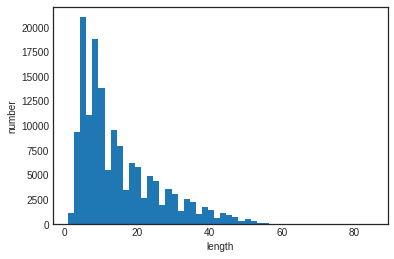

In [ ]:
#리뷰의 최대 길이, 평균 길이 확인
print('리뷰의 최대 길이: ', max(len(l) for l in X_train))
print('리뷰의 평균 길이: ', sum(map(len, X_train))/len(X_train)) #map(function, iterable): 첫 번째 매개변수로는 함수, 두 번째 매개변수로는 반복 가능한 자료형(리스트, 튜플 등)이 옴

#시각화
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length')
plt.ylabel('number')
plt.show()

In [ ]:
#max_len 정하기 위한 함수 
def sentence(max_len, list):
  count = 0
  for s in list:
    if(len(s) < max_len):
      count += 1
  print('길이가 %s 이하인 비율: %s'%(max_len, (count / len(list))*100))

In [ ]:
sentence(50, X_train)

길이가 50 이하인 비율: 99.11692122990729


In [ ]:
#max_len=50으로 맞추기
max_len=50
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

- GRU로 감성 분류 시행

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))  #임베딩 벡터 차원: 100
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid')) #0,1 이진 분류
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2178700   
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,267,149
Trainable params: 2,267,149
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#EarlyStopping: 검증 데이터 손실 4회 증가하면 학습을 조기 종료
#ModelCheckpoint: 검증 데이터 정확도가 전보다 좋아질 경우에만 모델을 저장

#loss는 최소화 시키는 방향으로 training이 진행되므로 min 지정
#verbose=1 로 지정하면, 언제 training 을 멈추었는지를 화면에 출력
#patience성능이 증가하지 않는 epoch 을 몇 번이나 허용할 것인가를 정의

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
#에포크는 총 10번 수행
#훈련 데이터 중 20%를 검증 데이터로 사용
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=10, callbacks=[es, mc], batch_size=100, validation_split=0.2)

Epoch 1/10
1200/1200 [==============================] - 26s 16ms/step - loss: 0.2763 - acc: 0.8950 - val_loss: 0.2329 - val_acc: 0.9158

Epoch 00001: val_acc improved from -inf to 0.91576, saving model to best_model.h5
Epoch 2/10
1200/1200 [==============================] - 18s 15ms/step - loss: 0.2161 - acc: 0.9225 - val_loss: 0.2116 - val_acc: 0.9231

Epoch 00002: val_acc improved from 0.91576 to 0.92313, saving model to best_model.h5
Epoch 3/10
1200/1200 [==============================] - 18s 15ms/step - loss: 0.1984 - acc: 0.9284 - val_loss: 0.2060 - val_acc: 0.9260

Epoch 00003: val_acc improved from 0.92313 to 0.92603, saving model to best_model.h5
Epoch 4/10
1200/1200 [==============================] - 18s 15ms/step - loss: 0.1865 - acc: 0.9328 - val_loss: 0.2023 - val_acc: 0.9263

Epoch 00004: val_acc improved from 0.92603 to 0.92627, saving model to best_model.h5
Epoch 5/10
1200/1200 [==============================] - 18s 15ms/step - loss: 0.1775 - acc: 0.9371 - val_loss: 0.20

In [ ]:
#검증 데이터의 정확도가 가장 높았을 때 저장된 모델 로드
loaded = load_model('best_model.h5')
loaded.evaluate(X_test, y_test)

1562/1562 [==============================] - 10s 6ms/step - loss: 0.2066 - acc: 0.9264


[0.20664027333259583, 0.9263661503791809]

- 리뷰 예측

In [ ]:
def predict(sentence):
  sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', sentence)
  sentence = mecab.morphs(sentence) #토큰화
  sentence = [word for word in sentence if not word in stopwords] #불용어 처리
  encoded = tokenizer.texts_to_sequences([sentence]) #정수 인코딩
  pad = pad_sequences(encoded, maxlen=max_len) #패딩
  score = float(loaded.predict(pad)) #예측
  if score > 0.5:
    print("{:.2f}% 확률로 긍정 리뷰".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰".format((1-score) * 100))

In [ ]:
predict('예쁜 줄 알고 샀는데 생각보다는 그렇게 예쁘지는 않다')
predict('흠 매우 애매함,, 뭔가 4점주긴 아깝고, 2점주긴 괜찮고')
predict('역시 리뷰를 보고 사니 실패하지 않네') #왜 부정 리뷰로 나올까,, 
predict('생각보단 괜찮음')

86.47% 확률로 부정 리뷰
86.84% 확률로 부정 리뷰
56.56% 확률로 부정 리뷰
56.72% 확률로 긍정 리뷰


# BERT 모델을 이용한 감정 분석 모델 

- transformers 설치, 필요한 라이브러리 설치

In [ ]:
#Hugging Face 트랜스포머 모델 설치
!pip install transformers

In [11]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import urllib.request

import pandas as pd
import numpy as np
import random
import time
import datetime

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- 전처리

> train data

In [14]:
#리뷰 문장
sentences = train['reviews']
sentences[:10]

0    사이즈를 3센치씩 늘린건데도 작아요 그리고 색상은 완전 달라요 칙칙한핑크네요ㅠㅠ 많...
1                       ㅂ불만족.. 빗이 아픔 .. 멍이피부에 빗질못해주겟네요
2    이 제품쓰고 삼일만에 변기물이 잘 안내려갔어요. 혹시나해서 다시 빼보니 물이 다시 ...
3                                           적당하고 만족합니다
4                     편하자고 이용하는 밀키튼데 손 은근 많이 가서 저는 패쓰요
5                                  아기 어릴때부터 항상 써오던거에요~
6                                     너무좋가겨 방금우리집데도둑기다
7    몸에 좋은 카카오닙스 강력 추천 배송도 빠르고 지프펙으로 250g 2팩 왔네요. 보...
8                              바르먄 건조해요. 아직 잘 모르겠다는 ㅡㅡ
9                     빠른배송~슬림핏이라서 너무 타잇하면어쩌나했는데 딱이쁩니다~
Name: reviews, dtype: object

In [15]:
#BERT INPUT 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 사이즈를 3센치씩 늘린건데도 작아요 그리고 색상은 완전 달라요 칙칙한핑크네요ㅠㅠ 많이 아쉽지만 암막효과는 좋아요 [SEP]',
 '[CLS] ㅂ불만족.. 빗이 아픔 .. 멍이피부에 빗질못해주겟네요 [SEP]',
 '[CLS] 이 제품쓰고 삼일만에 변기물이 잘 안내려갔어요. 혹시나해서 다시 빼보니 물이 다시 잘 내려가네요.., 이 많은걸 다 어쩌나요, ..반품하고싶다.., [SEP]',
 '[CLS] 적당하고 만족합니다 [SEP]',
 '[CLS] 편하자고 이용하는 밀키튼데 손 은근 많이 가서 저는 패쓰요 [SEP]',
 '[CLS] 아기 어릴때부터 항상 써오던거에요~ [SEP]',
 '[CLS] 너무좋가겨 방금우리집데도둑기다 [SEP]',
 '[CLS] 몸에 좋은 카카오닙스 강력 추천 배송도 빠르고 지프펙으로 250g 2팩 왔네요. 보관도 쉽고 먹기도 편합니다.올해는 건강하게 출발할거 같네요.ㅎㅎㅎ [SEP]',
 '[CLS] 바르먄 건조해요. 아직 잘 모르겠다는 ㅡㅡ [SEP]',
 '[CLS] 빠른배송~슬림핏이라서 너무 타잇하면어쩌나했는데 딱이쁩니다~ [SEP]']

In [16]:
#라벨
labels = train['label'].values
labels

array([0, 0, 0, ..., 0, 1, 1])

In [17]:
#BERT 토크나이저로 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized = [tokenizer.tokenize(s) for s in sentences]

print(sentences[0], tokenized[0])

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

[CLS] 사이즈를 3센치씩 늘린건데도 작아요 그리고 색상은 완전 달라요 칙칙한핑크네요ㅠㅠ 많이 아쉽지만 암막효과는 좋아요 [SEP] ['[CLS]', '사', '##이', '##즈', '##를', '3', '##센', '##치', '##씩', '늘', '##린', '##건', '##데', '##도', '작', '##아', '##요', '그리고', '색', '##상', '##은', '완', '##전', '달', '##라', '##요', '[UNK]', '많이', '아', '##쉽', '##지만', '암', '##막', '##효', '##과', '##는', '좋', '##아', '##요', '[SEP]']


In [19]:
MAX_LEN = 128 #최대 시퀀스 길이
input = [tokenizer.convert_tokens_to_ids(x) for x in tokenized] #토큰 -> 숫자 인덱스로 변환
input = pad_sequences(input, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post") #문장 MAX_LEN 길이에 맞추고, 모자란 부분은 패딩 0

input[0]

array([   101,   9405,  10739,  24891,  11513,    124, 119044,  18622,
       119108,   9044,  27654,  71439,  28911,  12092,   9652,  16985,
        48549,  23289,   9416,  14871,  10892,   9591,  16617,   9061,
        17342,  48549,    100,  47058,   9519, 119072,  28578,   9526,
       118907, 119449,  11882,  11018,   9685,  16985,  48549,    102,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [20]:
#BERT의 경우 제로 패딩으로 입력된 토큰 -> 항상 마스킹 처리, 이 토큰에 대해서는 페널티 부과해 어텐션 점수를 받지 못하도록 구현
attentionmask = [] #어텐션 마스크 

for sequence in input:
    seq_mask = [float(i > 0) for i in sequence] #어텐션 마스크: 패딩이 아니면 1, 패딩이면 0
    attentionmask.append(seq_mask)

print(attentionmask[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [21]:
#train/val 분리
train_input, val_input, train_labels, val_labels = train_test_split(input, labels, random_state=42, test_size=0.1)

#어텐션 마스크 -> train/val 분리
train_masks, val_masks, _, _ = train_test_split(attentionmask,input,random_state=42, test_size=0.1)

#Pytorch 텐서(코어 데이터 구조)로 변환
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

val_input = torch.tensor(val_input)
val_labels = torch.tensor(val_labels)
val_masks = torch.tensor(val_masks)				

In [22]:
#배치 사이즈
batch_size = 32

#Pytorch DataLoader로 input, masks, labels 묶어 데이터 설정
#train
train_data = TensorDataset(train_input, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size) #학습 시 batch size만큼 데이터 가져옴
#val
val_data = TensorDataset(val_input, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

> test data

In [23]:
#리뷰 문장
sentences = test['reviews']
sentences[:10]

0                                  너무 낮고 솜도 적고 실망스럽습니다
1                                     피부에 뾰루지가 많이 올라와요
2      배송도 빠르네요 가격대비 좋은것 같아요~~~ 첨에는 힘들어하나 조금 지나니 잘 하네요
3                             재구매입니다. 핏도 좋고 착용감도 좋습니다.
4          파손제품 온거 출장같다 오늘 받았는데 현재상황 장난하시는지 택배회사 항의하세요
5                          솔벤트 뚜껑이 약간 열려 있어서 용액이 셌어요 ㅠ
6                                      갈색병보다 좋은듯 정말잘맞ㅁ
7                  너무 작아저서 못쓰고있어요ㅠ 몇번빠니까 작아저서 ㅠ 속상합니다ㅠ
8    제품설명 상세페이지 어디에도 중국에서 제조한다는 표기가 없었는데 받아보고 중국제조라...
9                             재구매 좋겠죵. 항상 믿고 구매하는 곳입니다
Name: reviews, dtype: object

In [24]:
#BERT INPUT 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 너무 낮고 솜도 적고 실망스럽습니다 [SEP]',
 '[CLS] 피부에 뾰루지가 많이 올라와요 [SEP]',
 '[CLS] 배송도 빠르네요 가격대비 좋은것 같아요~~~ 첨에는 힘들어하나 조금 지나니 잘 하네요 [SEP]',
 '[CLS] 재구매입니다. 핏도 좋고 착용감도 좋습니다. [SEP]',
 '[CLS] 파손제품 온거 출장같다 오늘 받았는데 현재상황 장난하시는지 택배회사 항의하세요 [SEP]',
 '[CLS] 솔벤트 뚜껑이 약간 열려 있어서 용액이 셌어요 ㅠ [SEP]',
 '[CLS] 갈색병보다 좋은듯 정말잘맞ㅁ [SEP]',
 '[CLS] 너무 작아저서 못쓰고있어요ㅠ 몇번빠니까 작아저서 ㅠ 속상합니다ㅠ [SEP]',
 '[CLS] 제품설명 상세페이지 어디에도 중국에서 제조한다는 표기가 없었는데 받아보고 중국제조라는걸 알고 좀 당황스러웠네요 반품해야하나 고민했는데 그냥 써보려구요 상세페이지에 표기하셔야 할것 같아요 [SEP]',
 '[CLS] 재구매 좋겠죵. 항상 믿고 구매하는 곳입니다 [SEP]']

In [27]:
#라벨
labels = test['label'].values
labels

array([0, 0, 1, ..., 1, 1, 0])

In [28]:
#BERT 토크나이저로 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized = [tokenizer.tokenize(s) for s in sentences]

print (sentences[0], tokenized[0])

[CLS] 너무 낮고 솜도 적고 실망스럽습니다 [SEP] ['[CLS]', '너', '##무', '낮', '##고', '솜', '##도', '적', '##고', '실', '##망', '##스', '##럽', '##습', '##니다', '[SEP]']


In [29]:
MAX_LEN = 128 #최대 시퀀스 길이
input = [tokenizer.convert_tokens_to_ids(x) for x in tokenized] #토큰 -> 숫자 인덱스로 변환 
input = pad_sequences(input, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post") #문장 MAX_LEN 길이에 맞추고, 모자란 부분은 패딩 0

print(input[0])

[   101   9004  32537   8992  11664   9452  12092   9664  11664   9489
  89292  12605 118867 119081  48345    102      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0]


In [31]:
#BERT의 경우 제로 패딩으로 입력된 토큰 -> 항상 마스킹 처리, 이 토큰에 대해서는 페널티 부과해 어텐션 점수를 받지 못하도록 구현
attentionmask = [] #어텐션 마스크 

for sequence in input:
    seq_mask = [float(i > 0) for i in sequence] #어텐션 마스크: 패딩이 아니면 1, 패딩이면 0
    attentionmask.append(seq_mask)

print(attentionmask[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [32]:
#Pytorch 텐서(코어 데이터 구조)로 변환
test_input = torch.tensor(input)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attentionmask)

In [33]:
#배치 사이즈
batch_size = 32

#Pytorch DataLoader로 input, masks, labels 묶어 데이터 설정
#test
test_data = TensorDataset(test_input, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

- 모델 생성

In [34]:
device_name = tf.test.gpu_device_name() #GPU 디바이스 이름

#GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [35]:
#GPU 체크 및 할당
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [36]:
#분류 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [37]:
#옵티마이저: transformers에서 제공하는 옵티마이저 AdamW를 사용
optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8) # 0으로 나누는 것을 방지하기 위한 epsilon 값

#에폭
epochs = 4

#총 훈련 스텝 : 배치반복 횟수(이터레이션) * 에폭
total_steps = len(train_dataloader) * epochs

#처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

- 모델 학습

In [38]:
#accuracy 표시
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

#time 표시
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed))) # 반올림
    return str(datetime.timedelta(seconds=elapsed_rounded)) #hh:mm:ss으로 형태 변경

In [40]:
#데이터로더에서 배치만큼 가져온 후 forward, backward pass 수행

seed_val = 42 #랜덤시드 고정
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#그래디언트 초기화
model.zero_grad()

#에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ==============
    #    Training
    # ==============

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    #시작 시간 설정
    t0 = time.time()

    #로스 초기화
    total_loss = 0

    #훈련모드로 변경
    model.train()
        
    #데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        #배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        #배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        #Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        #로스 구함
        loss = outputs[0]

        #총 로스 계산
        total_loss += loss.item()

        #Backward 수행으로 그래디언트 계산
        loss.backward()

        #그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        #그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        #스케줄러로 학습률 감소
        scheduler.step()

        #그래디언트 초기화
        model.zero_grad()

    #평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ==============
    #   Validation
    # ==============

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    #평가모드로 변경
    model.eval()

    #변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    #데이터로더에서 배치만큼 반복하여 가져옴
    for batch in val_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        #그래디언트 계산 안함
        with torch.no_grad():     
            #Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        #로스 구함
        logits = outputs[0]

        #CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        #출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))


======== Epoch 1 / 4 ========
Training...
  Batch   500  of  4,217.    Elapsed: 0:05:54.
  Batch 1,000  of  4,217.    Elapsed: 0:11:49.
  Batch 1,500  of  4,217.    Elapsed: 0:17:45.
  Batch 2,000  of  4,217.    Elapsed: 0:23:40.
  Batch 2,500  of  4,217.    Elapsed: 0:29:36.
  Batch 3,000  of  4,217.    Elapsed: 0:35:31.
  Batch 3,500  of  4,217.    Elapsed: 0:41:26.
  Batch 4,000  of  4,217.    Elapsed: 0:47:22.

  Average training loss: 0.16
  Training epcoh took: 0:49:56

Running Validation...
  Accuracy: 0.92
  Validation took: 0:01:54

======== Epoch 2 / 4 ========
Training...
  Batch   500  of  4,217.    Elapsed: 0:05:56.
  Batch 1,000  of  4,217.    Elapsed: 0:11:51.
  Batch 1,500  of  4,217.    Elapsed: 0:17:47.
  Batch 2,000  of  4,217.    Elapsed: 0:23:42.
  Batch 2,500  of  4,217.    Elapsed: 0:29:38.
  Batch 3,000  of  4,217.    Elapsed: 0:35:33.
  Batch 3,500  of  4,217.    Elapsed: 0:41:29.
  Batch 4,000  of  4,217.    Elapsed: 0:47:24.

  Average training loss: 0.18
  

- 테스트셋

In [41]:
#시작 시간 설정
t0 = time.time()

#평가모드로 변경
model.eval()

#변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

#데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    #경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    #배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    #배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    #로스 구함
    logits = outputs[0]

    #CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    #출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

  Batch   100  of  1,562.    Elapsed: 0:00:24.
  Batch   200  of  1,562.    Elapsed: 0:00:48.
  Batch   300  of  1,562.    Elapsed: 0:01:13.
  Batch   400  of  1,562.    Elapsed: 0:01:37.
  Batch   500  of  1,562.    Elapsed: 0:02:01.
  Batch   600  of  1,562.    Elapsed: 0:02:26.
  Batch   700  of  1,562.    Elapsed: 0:02:50.
  Batch   800  of  1,562.    Elapsed: 0:03:14.
  Batch   900  of  1,562.    Elapsed: 0:03:39.
  Batch 1,000  of  1,562.    Elapsed: 0:04:03.
  Batch 1,100  of  1,562.    Elapsed: 0:04:27.
  Batch 1,200  of  1,562.    Elapsed: 0:04:51.
  Batch 1,300  of  1,562.    Elapsed: 0:05:16.
  Batch 1,400  of  1,562.    Elapsed: 0:05:40.
  Batch 1,500  of  1,562.    Elapsed: 0:06:04.

Accuracy: 0.92
Test took: 0:06:19


- 리뷰 예측

In [42]:
# 입력 데이터 변환
def convert_input_data(sentences):
    #토크나이저로 문장 -> 토큰으로 분리
    tokenized = [tokenizer.tokenize(s) for s in sentences]
    #최대 시퀀스 길이
    MAX_LEN = 128
    #토큰 -> 숫자 인덱스로 변환
    input = [tokenizer.convert_tokens_to_ids(x) for x in tokenized]
    #문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0
    input = pad_sequences(input, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    #어텐션 마스크 초기화
    attentionmask = []

    #어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    for seq in input:
        seq_mask = [float(i>0) for i in seq]
        attentionmask.append(seq_mask)

    #데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input)
    masks = torch.tensor(attentionmask)

    return inputs, masks

In [43]:
#문장 테스트
def test_sentences(sentences):

    #평가모드로 변경
    model.eval()
    #문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)
    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)      
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]
    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [44]:
logits = test_sentences(['예쁜 줄 알고 샀는데 생각보다는 그렇게 예쁘지는 않다'])

print(logits)
print(np.argmax(logits))

[[ 2.3514857 -2.4168046]]
0


In [45]:
logits = test_sentences(['흠 매우 애매함,, 뭔가 4점주긴 아깝고, 2점주긴 괜찮고'])

print(logits)
print(np.argmax(logits))

[[ 2.9188883 -2.9486833]]
0


In [46]:
logits = test_sentences(['역시 리뷰를 보고 사니 실패하지 않네']) 

print(logits)
print(np.argmax(logits)) #GRU 모델처럼 여기서도 부정리뷰로 나옴

[[ 2.4488897 -2.4136095]]
0


In [47]:
logits = test_sentences(['생각보단 괜찮음'])

print(logits)
print(np.argmax(logits))

[[-1.054081   1.1439103]]
1
